## This notebook details practicing and playing around with Millar et al's R code for automatic event delineation and hysteresis calcs using the s::can and discharge data from 2022

- Data from SV's email on 05.23.24 in `hb_q_chem copy.csv`

In [27]:
#################
# LOAD PACKAGES #
#################

library(tidyverse)
library(viridis)
library(dplyr)
library(lubridate)

###################
# SET DIRECTORIES #
###################

# Define the input and output directories

# For Kincaid data, input and output in separate directory
input_dir <- "/home/millieginty/Documents/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/"
output_dir <- "/home/millieginty/Documents/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/millar_code_out/"

# functions script in main millar directory
millar_input_dir <- "/home/millieginty/Documents/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/"

#####################
# READ IN FUNCTIONS #
#####################

# MED note: I haven't altered anything in this functions script
source(file.path("/home/millieginty/Documents/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/cQ_functions.R"))

################
# READ IN DATA #
################

# Read in raw data
# Downloaded on 05.27.24

allInputData15Min <- read.csv(file.path(input_dir,"hb_q_chem copy.csv"))


# Filter the data for just Hungerford Brook for the year/time range you want
# Remove rows with missing values
Hford <- allInputData15Min %>%
  filter(year(datetime) == 2022) %>%
  drop_na(q_cms_hb, NO3) %>%
  select(datetime, q_cms = q_cms_hb, conc = NO3)

# Specify constituent in data set name
dataSetName <- "HF_NO3"

# Chose constitution for plot axes labels (NO3, TOC, or turbidity)
constit <- "NO3"

Hford$datetime <- ymd_hms(Hford$datetime)

# Filter into just winter
Hford <- Hford %>%
  filter(between(datetime, as.Date("2022-02-01"), as.Date("2022-04-20"))) 

# Rescale the data
Hford <- Hford %>% 
  mutate(rescaled_conc = ((conc-min(conc))/(max(conc)-min(conc))*max(q_cms)))

# Vector containing candidate baseflow separation filter values
candidateFilterPara <- c(0.996,0.98)

# Vector containing candidate stormflow threshold values
candidateSfThresh <- c(0.088,0.1,0.14) # MED HF guess values; Kincaid et al 2020 used 0,1

# Vector with interpolation intervals used for calculating HI
interp <- seq(0,1,0.01)

Hford

datetime,q_cms,conc,rescaled_conc
<dttm>,<dbl>,<dbl>,<dbl>
2022-02-01 00:00:00,0.4360646,3.996297,7.392231
2022-02-01 00:15:00,0.4283612,3.988921,7.378580
2022-02-01 00:30:00,0.4360646,3.993206,7.386510
2022-02-01 00:45:00,0.4245386,3.991121,7.382652
2022-02-01 01:00:00,0.4245386,3.990592,7.381673
2022-02-01 01:15:00,0.4283612,4.004893,7.408140
2022-02-01 01:30:00,0.4322032,4.000987,7.400911
2022-02-01 01:45:00,0.4245386,3.993409,7.386886
2022-02-01 02:00:00,0.4245386,3.999041,7.397309


### Now, running the Millar code to get hysteresis indices

In [35]:
##########################################
# RUN ANALYSIS TO GET HYSTERESIS INDICES #
##########################################

batchRun1 <- batchRunBfAndEvSepForCQ(qInputs = Hford,
                                     bfSepPasses = 9, # orig 3
                                     filterParam = candidateFilterPara,
                                     sfSmoothPasses = 4, # orig 4
                                     sfThresh = candidateSfThresh,
                                     cInputs = Hford,
                                     timeStep = 15,
                                     minDuration = 2,
                                     maxDuration = 200)

eventsDataAll1 <- getAllStormEvents(batchRun = batchRun1,
                                    timestep_min = 15)

batchRunFlowsLF1 <- batchRunflowCompare(qData = Hford,
                                         bfSepPasses = 4, # orig 4
                                         filterPara = candidateFilterPara,
                                         sfSmoothPasses = 4) # orig 4

eventsData1 <- stormEventCalcs(batchRun = batchRun1,
                               timestep_min = 15)

stormCounts1 <- stormCounts(batchRun1)

hysteresisData1 <- getHysteresisIndices(batchRun = batchRun1,
                                        xForInterp = interp,
                                        eventsData = eventsData1)


Warning message in left_join(stormIds, conc, by = "datetime"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 17 of `x` matches multiple rows in `y`.
ℹ Row 17 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence
  this warning.”
Warning message in left_join(stormIds, conc, by = "datetime"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 17 of `x` matches multiple rows in `y`.
ℹ Row 17 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence
  this warning.”
Warning message in left_join(stormIds, conc, by = "datetime"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 17 of `x` matches multiple rows in `y`.
ℹ Row 17 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence
  this wa

### Export the results

In [36]:
######################
# EXPORT OUTPUT DATA #
######################

write.csv(eventsData1,file = file.path(output_dir,paste(dataSetName,"_StormEventSummaryData.csv",sep="")))
write.csv(batchRunFlowsLF1,file = file.path(output_dir,paste(dataSetName,"_DischargeData.csv",sep="")))
write.csv(hysteresisData1,file = file.path(output_dir,paste(dataSetName,"_HysteresisData.csv",sep="")))
write.csv(eventsDataAll1,file = file.path(output_dir,paste(dataSetName,"_AllCQData.csv",sep="")))
write.csv(stormCounts1,file = file.path(output_dir,paste(dataSetName,"_StormCounts.csv",sep="")))

### Plot and save event delineation data

In [37]:
#########################################
# PLOT AND SAVE DATA - EVENT SEPARATION #
#########################################

# Make subfolder in output directory to save hydrograph plots
dir.create(file.path(output_dir, "Hydrographs"), showWarnings = FALSE)

# 1) Plot and save the hydrograph with input data
# MED note that for the Kincaid data I had to change 'timestamp' to 'datetime'when reading in the csv

initialHydrograph <- ggplot(Hford,aes(x=datetime, y=q_cms)) +
                            geom_line(size=0.5, color="black") +
                            xlab(NULL) +
                            ylab(expression(paste("Total discharge (",m^3," ",s^-1,")"))) +
                            theme_bw() +
                            theme(text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_TotalDischarge.jpeg")),
       initialHydrograph,
       width = 12, 
       height = 4, 
       units = "in",
       dpi=600)

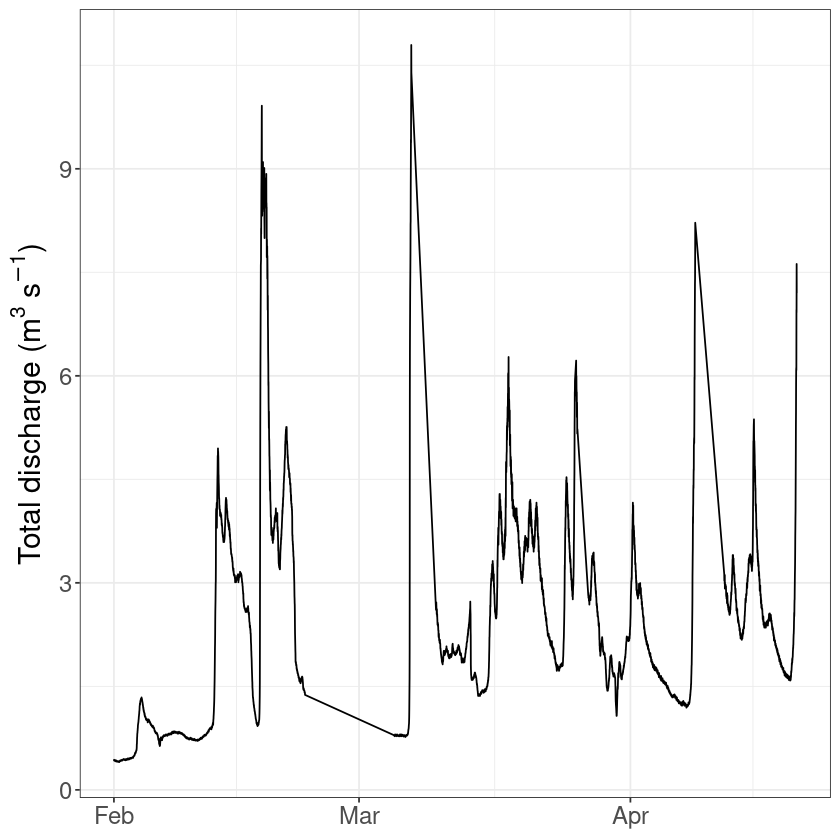

In [32]:
initialHydrograph

In [38]:
#########################################
# PLOT AND SAVE DATA - EVENT SEPARATION #
#########################################

# Make subfolder in output directory to save hydrograph plots
dir.create(file.path(output_dir, "Hydrographs"), showWarnings = FALSE)

# 1) Plot and save the hydrograph with input data
# MED note that for the Kincaid data I had to change 'timestamp' to 'datetime'when reading in the csv

initialHydrograph <- ggplot(Hford,aes(x=datetime, y=q_cms)) +
                            geom_line(size=0.5, color="black") +
                            xlab(NULL) +
                            ylab(expression(paste("Total discharge (",m^3," ",s^-1,")"))) +
                            theme_bw() +
                            theme(text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_TotalDischarge.jpeg")),
       initialHydrograph,
       width = 12, 
       height = 4, 
       units = "in",
       dpi=600)


# 2) Plot total discharge with baseflow

baseflowHydrograph <- ggplot() + 
                            geom_line(data=batchRunFlowsLF1, aes(x=datetime, y=total_flow), size=0.5, color="black") +
                            geom_line(data=batchRunFlowsLF1, aes(x=datetime, y=base_flow,color=filter_para), size=0.75) +
                            scale_color_brewer(palette = "Set1") +
                            xlab(NULL) +
                            ylab(expression(paste("Discharge (",m^3," ",s^-1,")"))) +
                            theme_bw() +
                            theme(legend.title = element_blank(),
                                  text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_Baseflows.jpeg")),
       baseflowHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)


# 3) Plot smoothed storm flows

stormflowHydrograph <- ggplot() + 
  geom_line(data=batchRunFlowsLF1, aes(x=datetime, y=storm_flow,color=filter_para), size=0.75) +
  scale_color_brewer(palette = "Set1") +
  xlab(NULL) +
  ylab(expression(paste("Storm flow (",m^3," ",s^-1,")"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_StormflowsOnly.jpeg")),
       stormflowHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)


# 3a) Plot smoothed storm flows with storm flow thresholds

stormflowThreshHydrograph <- ggplot() + 
  geom_line(data=batchRunFlowsLF1, aes(x=datetime, y=storm_flow,color=filter_para), size=0.75) +
  scale_color_brewer(palette = "Set1") +
  geom_hline(yintercept = candidateSfThresh, linetype = "dashed", color = "black",alpha=0.5) +
  xlab(NULL) +
  ylab(expression(paste("Storm flow (",m^3," ",s^-1,")"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text=element_text(size=18))

ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_StormflowsOnlyWithThresholds.jpeg")),
       stormflowThreshHydrograph,
       width = 14, 
       height = 4, 
       units = "in",
       dpi=600)


# 4) Plot batch run event separation hydrographs
eventsDataShaded1 <- eventsData1 %>% mutate(start = as.POSIXct(start,
                                                                   format("%Y-%m-%d %H:%M:%S"),tz="EST"),
                                            end = as.POSIXct(end,
                                                                   format("%Y-%m-%d %H:%M:%S"),tz="EST"),
                                            tops = max(Hford$q_cms),
                                            bottoms = 0)

batchEventSepPlot <- ggplot() + 
  geom_rect(data=eventsDataShaded1, mapping=aes(xmin=start, 
                                                xmax=end, 
                                                ymin=bottoms, 
                                                ymax=tops), fill="green", color="red", alpha=0.2) +
  
  geom_line(data=Hford, aes(x=datetime, y=q_cms), size=0.8, color="blue") +
  geom_line(data=Hford, aes(x=datetime, y=rescaled_conc), size=0.5, color="black",linetype="dashed") +
  facet_wrap(~ run_id, ncol = 1) +
  scale_color_brewer(palette = "Set1") +
  xlab(NULL) +
  ylab(expression(paste("Discharge (",m^3," ",s^-1,")"))) +
  theme_bw() +
  theme(legend.title = element_blank(),
        text=element_text(size=18))


ggsave(file=file.path(output_dir,"Hydrographs",paste(dataSetName,"_BatchEventSeparationPlot.jpeg")),
       batchEventSepPlot,
       width = 8, 
       height = 10, 
       units = "in",
       dpi=600)


Warning message:
“Removed 4 rows containing missing values (`geom_rect()`).”


Warning message:
“Removed 4 rows containing missing values (`geom_rect()`).”


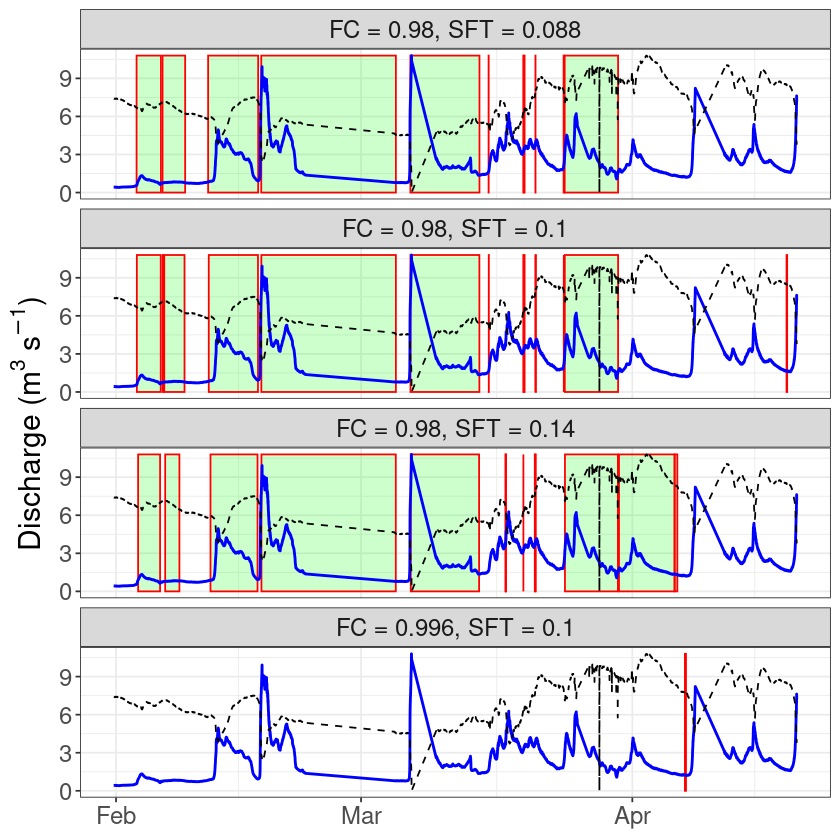

In [39]:
batchEventSepPlot

### Plotting and saving cQ output

In [18]:
####################################
# PLOT AND SAVE DATA - c-Q RESULTS #
####################################

if (constit == "NO3") {
  
  makeCQPlotsNO3(batchRun1)
  makeHystFlushPlotsNO3(hysteresisData1)
  
} else if (constit == "TOC") {

makeCQPlotsTOC(batchRun1)
makeHystFlushPlotsTOC(hysteresisData1)
  
} else if (constit == "turbity") {
    
makeCQPlotsTurb(batchRun1) 
makeHystFlushPlotsTurb(hysteresisData1)
  
}

Warning message:
“Removed 16 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 16 rows containing missing values (`geom_path()`).”
Warning message:
“Removed 88 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 88 rows containing missing values (`geom_path()`).”
Warning message:
“Removed 16 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 16 rows containing missing values (`geom_path()`).”
Warning message:
“Removed 72 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 72 rows containing missing values (`geom_path()`).”
Warning message:
“Removed 24 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 24 rows containing missing values (`geom_path()`).”
Warning message:
“Removed 68 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 68 rows containing missing values (`geom_path()`).”
